# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.1 MB/s eta 0:00:00


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 186
The number of columns: 494


In [11]:
# Bekijk de eerste rijen
print(data.head())

# Bekijk de kolomnamen en datatypes
print(data.dtypes)

# Samenvatting van de statistieken
print(data.describe())




                 label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                 
Liver-001_0     benign                                  0.878471   
Liver-002_0     benign                                  0.878945   
Liver-003_0     benign                                  0.766162   
Liver-004_0  malignant                                  0.825737   
Liver-005_0  malignant                                  0.828831   

             PREDICT_original_sf_compactness_std_2.5D  \
ID                                                      
Liver-001_0                                  0.023468   
Liver-002_0                                  0.039922   
Liver-003_0                                  0.064140   
Liver-004_0                                  0.062047   
Liver-005_0                                  0.062635   

             PREDICT_original_sf_rad_dist_avg_2.5D  \
ID                                                   
Liver-001_0    

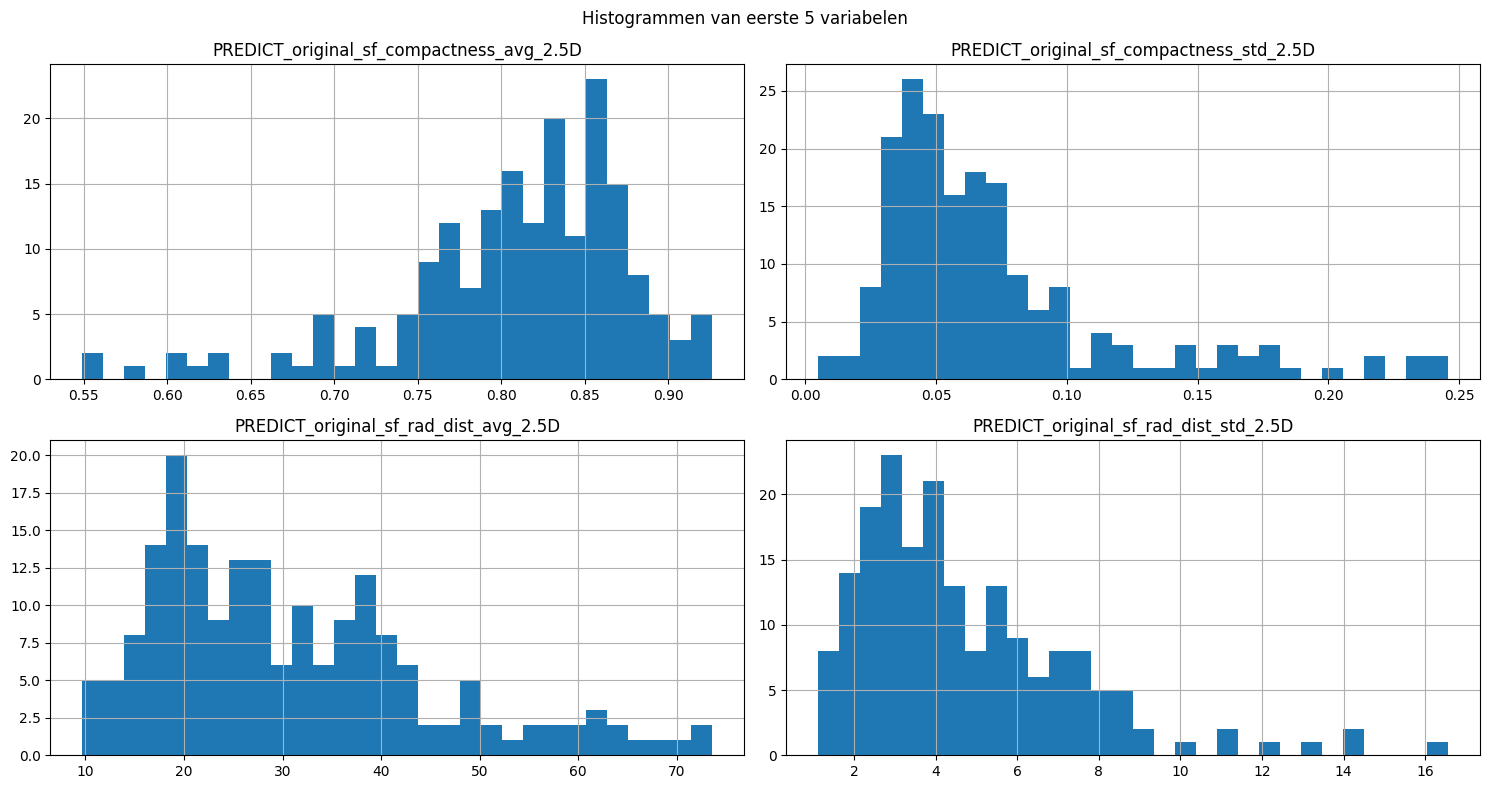

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogrammen voor de eerste paar kolommen (als voorbeeld)
data.iloc[:, :5].hist(figsize=(15, 8), bins=30)
plt.suptitle('Histogrammen van eerste 5 variabelen')
plt.tight_layout()
plt.show()


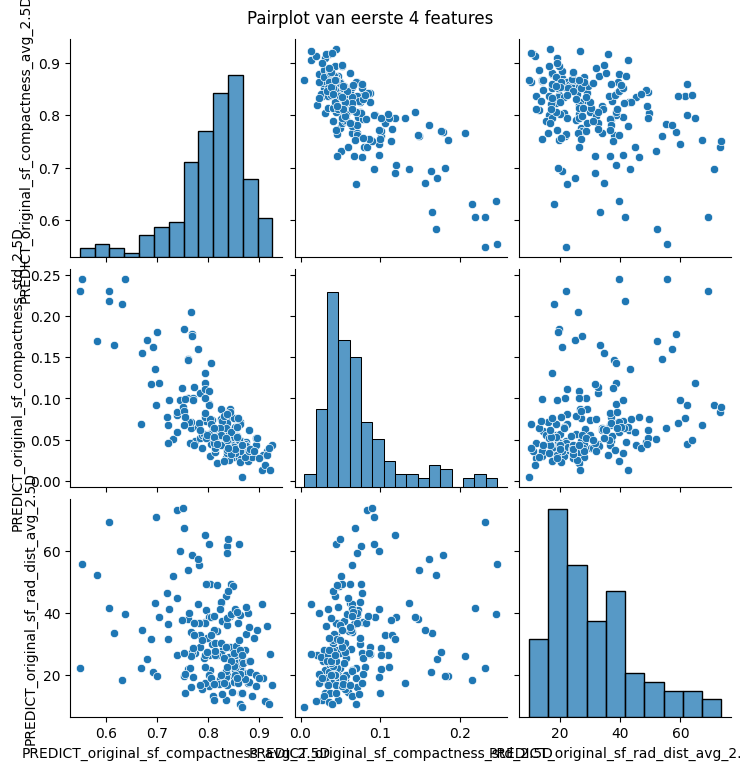

In [6]:
sns.pairplot(data.iloc[:, :4])  # neem alleen de eerste 4 kolommen om het overzichtelijk te houden
plt.suptitle("Pairplot van eerste 4 features", y=1.02)
plt.show()
